# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [12]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [13]:
# Install requirements
!python -m pip install -r requirements.txt





Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [14]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using cuda


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [16]:
# Define transforms
transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize(0,1,inplace=True),


])
# Create training set and define training dataloader
train_data = datasets.MNIST(root="data", train= True, transform = transform,download= True)
train_loader = DataLoader(train_data, batch_size= 64, shuffle= True)
# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train= False, transform = transform,download= True)
test_loader = DataLoader(test_data, batch_size= 64, shuffle= True)

In [17]:
for data in train_loader:
    print(data[0].shape, data[1].shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [18]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


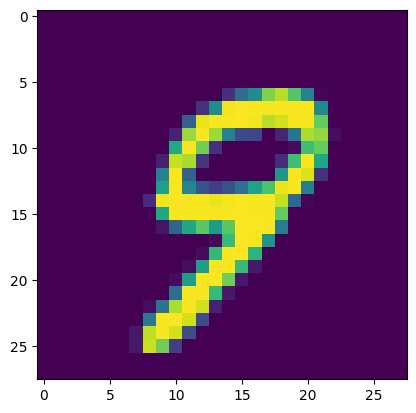

4


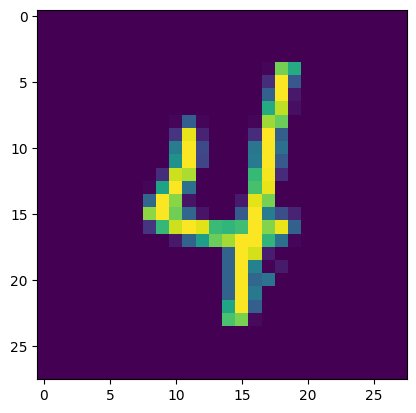

5


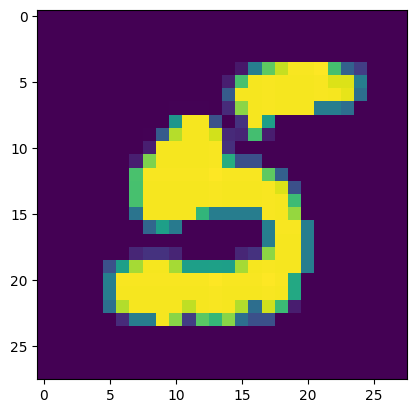

8


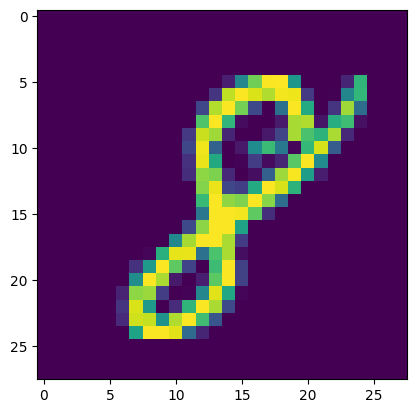

6


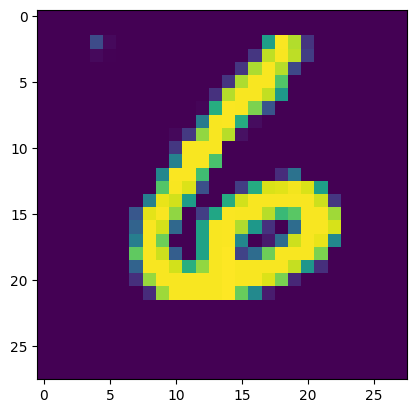

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

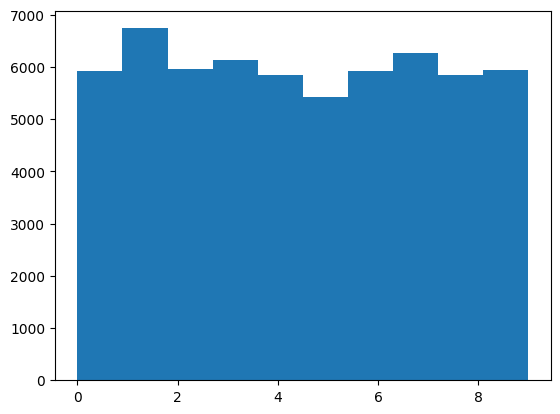

In [19]:
# Explore data
show5(train_loader)

# show labels's distribution
labels = []
for data in train_loader:
    labels += data[1].tolist()
plt.hist(labels, bins = 10) 

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [20]:
writer = SummaryWriter("runs/mnist")

In [21]:
class Model (nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)        
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [22]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001,)
lossses = []
accuracies = []
def train(model, dataloader,val_dataloader, epochs = 5):
    
    for epoch in range(epochs):
        model.train()
        for data in dataloader:
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            lossses.append(loss)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
        model.eval()
        train_correct = 0
        for data in val_dataloader:
            X, y = data
            X, y = X.to(device), y.to(device)
            output = model(X)
            train_correct += (torch.argmax(output, dim = 1) == y).float().sum()
        accuracy = train_correct/len(val_dataloader.dataset)
        accuracies.append(accuracy)
        print(f"Epoch: {epoch}. Loss: {loss}, Accuracy: {accuracy}")
        writer.add_scalar("Accuracy/train",accuracy, epoch)
        writer.flush()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [23]:
train(model, train_loader, test_loader, epochs = 20)

Epoch: 0. Loss: 0.15033094584941864, Accuracy: 0.9571999907493591
Epoch: 1. Loss: 0.0396912507712841, Accuracy: 0.9713999629020691
Epoch: 2. Loss: 0.053325802087783813, Accuracy: 0.973800003528595
Epoch: 3. Loss: 0.03443758934736252, Accuracy: 0.9768999814987183
Epoch: 4. Loss: 0.016788676381111145, Accuracy: 0.9791999459266663
Epoch: 5. Loss: 0.0072401221841573715, Accuracy: 0.9735999703407288
Epoch: 6. Loss: 0.025292128324508667, Accuracy: 0.9754999876022339
Epoch: 7. Loss: 0.0037560095079243183, Accuracy: 0.976099967956543
Epoch: 8. Loss: 0.003658225992694497, Accuracy: 0.977899968624115
Epoch: 9. Loss: 0.002731247106567025, Accuracy: 0.98089998960495
Epoch: 10. Loss: 0.0020075328648090363, Accuracy: 0.9822999835014343
Epoch: 11. Loss: 5.3585161367664114e-05, Accuracy: 0.9799000024795532
Epoch: 12. Loss: 0.05747276172041893, Accuracy: 0.9727999567985535
Epoch: 13. Loss: 0.00020078258239664137, Accuracy: 0.9811999797821045
Epoch: 14. Loss: 0.0014706222573295236, Accuracy: 0.971899986

Plot the training loss (and validation loss/accuracy, if recorded).

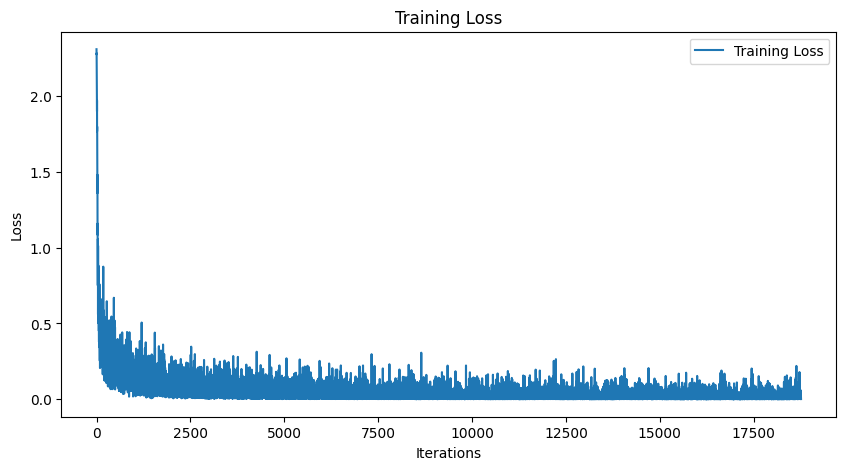

In [24]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot([loss.item() for loss in lossses], label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()



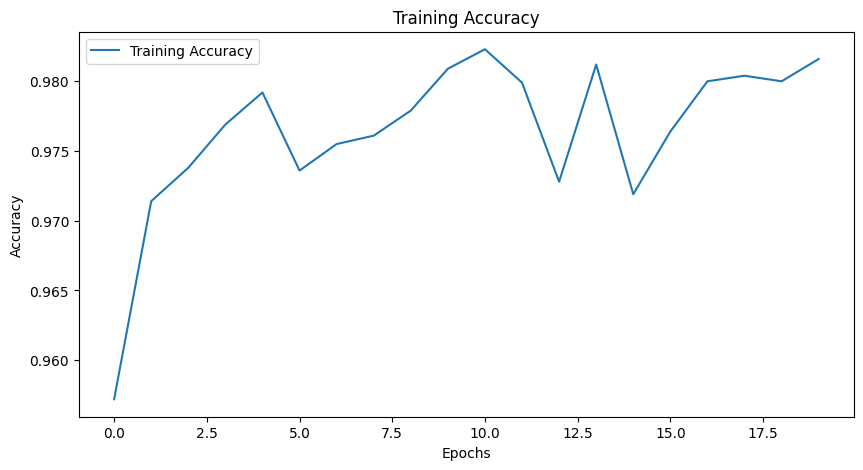

In [25]:
# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot([accuracy.item() for accuracy in accuracies], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [26]:
model.eval()
test_correct = 0
with torch.no_grad():
    for data in test_loader:
        X, y = data
        X, y = X.to(device), y.to(device)
        output = model(X)
        test_correct += (torch.argmax(output, dim=1) == y).float().sum()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy.item() * 100:.2f}%")

Test Accuracy: 98.16%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

## Saving your model
Using `torch.save`, save your model for future loading.

In [27]:
torch.save(model.state_dict(), 'mnist_model.pth')